# VAE Encoding Decoding

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import copy

CONFIG = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 1024,
    'latent_dim': 32,      # 1x32 向量 (满足 1xn 要求)
    'vae_epochs': 100,      # VAE 训练轮数
    'diff_epochs': 150,     # Diffusion 训练轮数
    'lr': 1e-3,
    'T': 10.0,              # 时间上限
    'dt': 0.01,            # 采样步长
}

os.makedirs("results", exist_ok=True)
print(f"Using device: {CONFIG['device']}")

Using device: cuda


In [86]:
transform = transforms.Compose([transforms.ToTensor()])
full_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
target_digit = 1  
indices = (full_dataset.targets == target_digit).nonzero(as_tuple=True)[0]
train_dataset = torch.utils.data.Subset(full_dataset, indices)
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)

In [87]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid() 
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def vae_loss_fn(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [95]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class ScoreNet(nn.Module):
    def __init__(self, latent_dim, hidden_dim=512):
        super().__init__()
        self.embed = GaussianFourierProjection(128)
        
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 128, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, t):
        t_embed = self.embed(t) 
        input_feat = torch.cat([x, t_embed], dim=1)
        return self.net(input_feat)

def marginal_prob_std(t):
    return torch.sqrt(1. - torch.exp(-2 * t))

def diffusion_coeff(t):
    return torch.tensor(np.sqrt(2)).to(t.device)

def drift_coeff(x, t):
    return -x

def loss_fn_diffusion(model, x, marginal_prob_std_func, eps=1e-3):
    batch_size = x.shape[0]
    random_t = torch.rand(batch_size, device=x.device) * (CONFIG['T'] - eps) + eps
    mean = x * torch.exp(-random_t)[:, None]
    std = marginal_prob_std_func(random_t)[:, None]
    z = torch.randn_like(x)
    perturbed_x = mean + std * z # x_t
    score = model(perturbed_x, random_t)
    h_t = std ** 2
    weight = 1 / (h_t)
    loss = torch.mean(weight * torch.sum((score * std + z)**2, dim=(1)))
    return loss

In [96]:
def euler_maruyama_sampler(score_model, latent_dim, batch_size=64, num_steps=1000):
    t_min = 1e-3
    t_max = CONFIG['T']
    device = CONFIG['device']
    
    q = (t_max / t_min) ** (1.0 / num_steps)
    time_points_np = np.array([t_max * (q ** (-i)) for i in range(num_steps + 1)])
    time_points = torch.tensor(time_points_np, device=device, dtype=torch.float32)

    x = torch.randn(batch_size, latent_dim).to(device)
    
    with torch.no_grad():
        for i in range(num_steps): 
            t_current = time_points[i]
            t_next = time_points[i + 1]
            dt = t_current - t_next

            t_batch = torch.ones(batch_size, device=device) * t_current
            
            std = marginal_prob_std(t_current)
            score = score_model(x, t_batch) / std
            
            drift = x + 2 * score
            
            diffusion = torch.sqrt(torch.tensor(2.0)) * torch.randn_like(x)
            
            x_mean = x + drift * dt 
            x = x_mean + diffusion * torch.sqrt(dt)
            
    return x


[Step 1] Training VAE...
VAE Epoch 1: Loss 480.60
VAE Epoch 2: Loss 212.47
VAE Epoch 3: Loss 123.18
VAE Epoch 4: Loss 106.51
VAE Epoch 5: Loss 100.52
VAE Epoch 6: Loss 100.00
VAE Epoch 7: Loss 98.44
VAE Epoch 8: Loss 97.46
VAE Epoch 9: Loss 96.16
VAE Epoch 10: Loss 95.27
VAE Epoch 11: Loss 94.73
VAE Epoch 12: Loss 94.10
VAE Epoch 13: Loss 93.37
VAE Epoch 14: Loss 92.19
VAE Epoch 15: Loss 89.37
VAE Epoch 16: Loss 84.32
VAE Epoch 17: Loss 79.09
VAE Epoch 18: Loss 74.97
VAE Epoch 19: Loss 72.18
VAE Epoch 20: Loss 70.27
VAE Epoch 21: Loss 69.31
VAE Epoch 22: Loss 68.70
VAE Epoch 23: Loss 68.28
VAE Epoch 24: Loss 67.84
VAE Epoch 25: Loss 67.59
VAE Epoch 26: Loss 67.19
VAE Epoch 27: Loss 66.98
VAE Epoch 28: Loss 66.52
VAE Epoch 29: Loss 66.42
VAE Epoch 30: Loss 66.07
VAE Epoch 31: Loss 65.73
VAE Epoch 32: Loss 65.29
VAE Epoch 33: Loss 64.72
VAE Epoch 34: Loss 64.03
VAE Epoch 35: Loss 63.39
VAE Epoch 36: Loss 62.65
VAE Epoch 37: Loss 61.87
VAE Epoch 38: Loss 61.50
VAE Epoch 39: Loss 60.99
VA

Encoding: 100%|██████████| 7/7 [00:00<00:00, 26.94it/s]


Latents saved to results/mnist_latents.pt

[Step 3] Training Latent Diffusion (ScoreNet)...
Diffusion Epoch 1: Loss 219.2961
  >> [New Best] Loss improved to 219.2961
Diffusion Epoch 2: Loss 1159.7594
Diffusion Epoch 3: Loss 244.5017
Diffusion Epoch 4: Loss 969.5834
Diffusion Epoch 5: Loss 2064.9171
Diffusion Epoch 6: Loss 543.3596
Diffusion Epoch 7: Loss 789.4957
Diffusion Epoch 8: Loss 951.4158
Diffusion Epoch 9: Loss 282.9462
Diffusion Epoch 10: Loss 1286.8932
Diffusion Epoch 11: Loss 583.1721
Diffusion Epoch 12: Loss 195.2314
  >> [New Best] Loss improved to 195.2314
Diffusion Epoch 13: Loss 261.6375
Diffusion Epoch 14: Loss 1010.9526
Diffusion Epoch 15: Loss 1025.3529
Diffusion Epoch 16: Loss 396.7844
Diffusion Epoch 17: Loss 993.2661
Diffusion Epoch 18: Loss 533.5475
Diffusion Epoch 19: Loss 1578.1444
Diffusion Epoch 20: Loss 231.7514
Diffusion Epoch 21: Loss 327.1597
Diffusion Epoch 22: Loss 245.5317
Diffusion Epoch 23: Loss 1073.5674
Diffusion Epoch 24: Loss 189.4597
  >> [New 

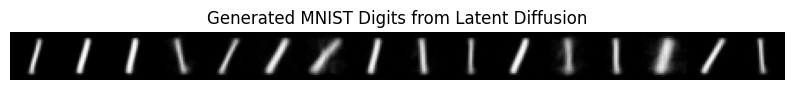

In [97]:
def main():
    print("\n[Step 1] Training VAE...")
    vae = VAE(CONFIG['latent_dim']).to(CONFIG['device'])
    optimizer_vae = optim.Adam(vae.parameters(), lr=CONFIG['lr'])

    vae.train()
    for epoch in range(CONFIG['vae_epochs']):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(CONFIG['device'])
            optimizer_vae.zero_grad()
            recon_x, mu, logvar = vae(x)
            loss = vae_loss_fn(recon_x, x, mu, logvar)
            loss.backward()
            optimizer_vae.step()
            total_loss += loss.item()
        print(f"VAE Epoch {epoch+1}: Loss {total_loss / len(train_dataset):.2f}")

    print("\n[Step 2] Extracting Latents...")
    vae.eval()
    all_latents = []
    all_labels = []
    
    with torch.no_grad():
        full_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
        for x, y in tqdm(full_loader, desc="Encoding"):
            x = x.to(CONFIG['device'])
            mu, _ = vae.encode(x) # 使用均值作为latent code
            all_latents.append(mu.cpu())
            all_labels.append(y)
    
    all_latents = torch.cat(all_latents, dim=0) # [60000, 32]
    all_labels = torch.cat(all_labels, dim=0)
    
    torch.save({'latents': all_latents, 'labels': all_labels}, 'results/mnist_latents.pt')
    print("Latents saved to results/mnist_latents.pt")

    print("\n[Step 3] Training Latent Diffusion (ScoreNet)...")
    latent_dataset = TensorDataset(all_latents)
    latent_loader = DataLoader(latent_dataset, batch_size=CONFIG['batch_size'], shuffle=True)

    score_model = ScoreNet(CONFIG['latent_dim']).to(CONFIG['device'])
    optimizer_diff = optim.Adam(score_model.parameters(), lr=0.0001)

    best_loss = float('inf')
    best_model_state = None

    score_model.train()
    for epoch in range(CONFIG['diff_epochs']):
        avg_loss = 0
        for z_batch in latent_loader:
            z0 = z_batch[0].to(CONFIG['device'])
            optimizer_diff.zero_grad()
            loss = loss_fn_diffusion(score_model, z0, marginal_prob_std)
            loss.backward()
            optimizer_diff.step()
            avg_loss += loss.item()
        epoch_loss = avg_loss / len(latent_loader)
        print(f"Diffusion Epoch {epoch+1}: Loss {avg_loss / len(latent_loader):.4f}")
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_state = copy.deepcopy(score_model.state_dict())
            print(f"  >> [New Best] Loss improved to {best_loss:.4f}")

    if best_model_state is not None:
        score_model.load_state_dict(best_model_state)
        print(f"\nTraining finished. Loaded best model with loss: {best_loss:.4f}")

    print("\n[Step 4] Saving Models...")
    torch.save(vae.state_dict(), 'results/vae_mnist.pth')
    torch.save(score_model.state_dict(), 'results/ldm_score_net.pth')
    print("Models saved.")

    print("\n[Step 5] Sampling from Latent Diffusion...")
    score_model.eval()
    vae.eval()
    
    # 采样 latent
    sampled_latents = euler_maruyama_sampler(score_model, CONFIG['latent_dim'], batch_size=16)
    
    # 解码为图像
    with torch.no_grad():
        sampled_images = vae.decode(sampled_latents).cpu()
    
    # 显示结果
    grid_img = torch.cat([sampled_images[i] for i in range(16)], dim=2) # 简单横向拼接
    plt.figure(figsize=(10, 2))
    plt.imshow(grid_img.squeeze(), cmap='gray')
    plt.title("Generated MNIST Digits from Latent Diffusion")
    plt.axis('off')
    plt.savefig('results/generated_samples.png')
    print("Sample image saved to results/generated_samples.png")


if __name__ == '__main__':
    main()

In [106]:
score_model = ScoreNet(CONFIG['latent_dim']).to(CONFIG['device'])
state_dict = torch.load('results/ldm_score_net.pth', map_location=CONFIG['device'], weights_only=True)
score_model.load_state_dict(state_dict)
def compute_log_prob_gmm(x_query, x_dataset, t):
    alpha_t = torch.exp(torch.tensor(-t))
    var_t = 1.0 - torch.exp(torch.tensor(-2.0 * t))
    sigma_t = torch.sqrt(var_t)
    means = x_dataset * alpha_t # [N, D]
    diff = x_query - means 
    sq_dist = torch.sum(diff ** 2, dim=1) 
    
    log_coeff = -0.5 * CONFIG['latent_dim'] * torch.log(2 * torch.pi * var_t)
    log_exps = -0.5 * sq_dist / var_t

    log_sum = torch.logsumexp(log_exps, dim=0)
    
    log_prob = log_sum - torch.log(torch.tensor(x_dataset.size(0))) + log_coeff
    return log_prob

def get_ridge_residual(x_point, x_dataset, t, d_star):
    device = x_point.device
    D = x_point.shape[0]
    
    x_pt = x_point.detach().to(dtype=torch.float64)
    x_data = x_dataset.detach().to(dtype=torch.float64)
    t_val = torch.tensor(t, device=device, dtype=torch.float64)
    
    alpha_t = torch.exp(-t_val)
    var_t = 1.0 - torch.exp(-2.0 * t_val)
    h_t = var_t 
    
    centers = alpha_t * x_data 
    diff = x_pt.unsqueeze(0) - centers 
    sq_dist = torch.sum(diff ** 2, dim=1) # [N]
    log_exps = -0.5 * sq_dist / h_t
    log_total = torch.logsumexp(log_exps, dim=0)
    gammas = torch.exp(log_exps - log_total) # [N]
    mean_mu = torch.sum(gammas.unsqueeze(1) * centers, dim=0) 
    grad = (mean_mu - x_pt) / h_t 

    sqrt_gammas = torch.sqrt(gammas).unsqueeze(1) # [N, 1]
    weighted_diff = sqrt_gammas * diff # [N, D]
    
    term1 = (weighted_diff.T @ weighted_diff) / (h_t ** 2)
    term2 = torch.eye(D, device=device, dtype=torch.float64) / h_t
    term3 = torch.outer(grad, grad)
    
    hessian = term1 - term2 - term3
    
    eig_vals, eig_vecs = torch.linalg.eigh(hessian)
    
    num_ortho = D - d_star
    E = eig_vecs[:, :num_ortho] # [D, num_ortho]
    proj = E @ E.T @ grad
    residual = torch.norm(proj) 
    
    check_index = D - 1 - d_star
    is_curvature_satisfied = eig_vals[check_index] < 0
    
    return residual.item(), is_curvature_satisfied.item()

def partial_sampler(score_model, latent_dim, batch_size, stop_t):
    t_min = 1e-3
    t_max = CONFIG['T']
    num_steps = 1000
    device = CONFIG['device']
    q = (t_max / t_min) ** (1.0 / num_steps)
    time_points_np = np.array([t_max * (q ** (-i)) for i in range(num_steps + 1)])
    t_seq = torch.tensor(time_points_np, device=device, dtype=torch.float32)
    
    x = torch.randn(batch_size, latent_dim).to(device)
    
    score_model.eval()
    with torch.no_grad():
        for i in range(num_steps):
            t_curr = t_seq[i]
            t_next = t_seq[i+1]
            dt = t_curr - t_next 
            if t_curr < stop_t:
                print(f"Sampling stopped at t = {t_curr.item():.5f} (Target: {stop_t})")
                return x, t_curr.item()

            t_batch = torch.ones(batch_size, device=device) * t_curr
            
            std = marginal_prob_std(t_curr)
            score = score_model(x, t_batch) / std 
            
            drift = x + 2 * score
            diffusion = torch.sqrt(torch.tensor(2.0)) * torch.randn_like(x)
            
            # Euler-Maruyama Step
            x_mean = x + drift * dt 
            x = x_mean + diffusion * torch.sqrt(dt)
            
    return x, t_seq[-1].item()

In [110]:
# --- 修改后的可视化函数 ---
def visualize_ridge_quality(sampled_latents, residuals, latent_dim, device, train_latents):
    """
    新增参数:
    train_latents: [N_train, D] 完整的训练集潜在向量，用于计算最近邻距离
    """
    print(f"\n[Viz] Loading VAE from results/vae_mnist.pth ...")
    vae = VAE(latent_dim).to(device)
    # 加载权重
    state_dict = torch.load('results/vae_mnist.pth', map_location=device, weights_only=True)
    vae.load_state_dict(state_dict)
    vae.eval()
    
    # 设定阈值
    threshold_low = 0.5   
    threshold_high = 0.6 
    
    if not isinstance(residuals, torch.Tensor): residuals = torch.tensor(residuals)
    if not isinstance(sampled_latents, torch.Tensor): sampled_latents = torch.tensor(sampled_latents)
    
    # 确保 train_latents 在正确的设备上
    if train_latents.device != device:
        train_latents = train_latents.to(device)

    idx_low = (residuals < threshold_low).nonzero(as_tuple=True)[0]
    idx_high = (residuals > threshold_high).nonzero(as_tuple=True)[0]
    
    print(f"[Viz] Found {len(idx_low)} samples on Ridge (<{threshold_low})")
    print(f"[Viz] Found {len(idx_high)} samples off Ridge (>{threshold_high})")
    
    num_show = 10
    
    def decode_and_show(indices, title_prefix):
        if len(indices) == 0: return
        
        # 随机抽取
        perm = torch.randperm(len(indices))[:num_show]
        selected_idx = indices[perm]
        
        selected_z = sampled_latents[selected_idx].to(device)
        selected_res = residuals[selected_idx]
        
        with torch.no_grad():
            dists_matrix = torch.cdist(selected_z, train_latents) 
            min_dists, _ = dists_matrix.min(dim=1) 
            
            images = vae.decode(selected_z).cpu()
            
        plt.figure(figsize=(15, 2.5)) 
        plt.suptitle(f"{title_prefix}\n(Mean Res: {selected_res.mean():.1f}, Mean Latent-Dist: {min_dists.mean():.2f})", fontsize=14, y=1.05)
        
        for i in range(len(selected_idx)):
            ax = plt.subplot(1, num_show, i+1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
        
            ax.set_title(f"R={selected_res[i]:.0f}\nNN={min_dists[i]:.2f}", fontsize=8)
            
        plt.show()

    decode_and_show(idx_low, "Low Residual (On Ridge)")
    decode_and_show(idx_high, "High Residual (Off Ridge)")

In [111]:
def main_analysis():
    print(f"Using device: {CONFIG['device']}")
    
    # --- A. 加载数据 ---
    print("Loading data...")
    data = torch.load('results/mnist_latents.pt', weights_only=True)
    all_latents = data['latents'].to(CONFIG['device'])
    all_labels = data['labels']

    x_dataset = all_latents
    target_stop_t = 0.001
    
    print(f"Sampling from model (stopping at t={target_stop_t})...")
    sampled_x, actual_t = partial_sampler(score_model, CONFIG['latent_dim'], 2000, target_stop_t)
    print(f"Actual analysis time t: {actual_t:.5f}")
    
    d_star = 25
    
    print(f"Computing Ridge Residuals for d*={d_star}, t={actual_t:.5f}...")
    
    residuals = []
    satisfied_curvature_count = 0
    
    for i in range(len(sampled_x)):
        x_query = sampled_x[i]
        res, is_curv = get_ridge_residual(x_query, x_dataset, actual_t, d_star)
        
        residuals.append(res)
        if is_curv:
            satisfied_curvature_count += 1
            
        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{len(sampled_x)} samples...")

    residuals = np.array(residuals) / np.max(residuals)
    
    print("\nPlotting Histogram...")
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of Ridge Residuals (t={actual_t:.4f})\n$||E(x)E(x)^T \\nabla \\log p_t(x)||$ (d*={d_star})')
    plt.xlabel('Residual Value (Closer to 0 means closer to Ridge)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--')
    
    plt.text(0.65, 0.75, 
             f"Mean: {residuals.mean():.4f}\n"
             f"Median: {np.median(residuals):.4f}\n"
             f"Curvature Satisfied: {satisfied_curvature_count/len(residuals)*100:.1f}%", 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.5))
    
    plt.savefig('results/ridge_analysis_random.png')
    print("Saved plot to results/ridge_analysis.png")

    print("\n[Step E] Visualizing Samples based on Ridge Residuals...")
    visualize_ridge_quality(
        sampled_x, 
        residuals, 
        CONFIG['latent_dim'], 
        CONFIG['device'],
        train_latents=all_latents
    )

Using device: cuda
Loading data...
Sampling from model (stopping at t=0.001)...
Actual analysis time t: 0.00100
Computing Ridge Residuals for d*=25, t=0.00100...
Processed 100/2000 samples...
Processed 200/2000 samples...
Processed 300/2000 samples...
Processed 400/2000 samples...
Processed 500/2000 samples...
Processed 600/2000 samples...
Processed 700/2000 samples...
Processed 800/2000 samples...
Processed 900/2000 samples...
Processed 1000/2000 samples...
Processed 1100/2000 samples...
Processed 1200/2000 samples...
Processed 1300/2000 samples...
Processed 1400/2000 samples...
Processed 1500/2000 samples...
Processed 1600/2000 samples...
Processed 1700/2000 samples...
Processed 1800/2000 samples...
Processed 1900/2000 samples...
Processed 2000/2000 samples...

Plotting Histogram...
Saved plot to results/ridge_analysis.png

[Step E] Visualizing Samples based on Ridge Residuals...

[Viz] Loading VAE from results/vae_mnist.pth ...
[Viz] Found 1422 samples on Ridge (<0.5)
[Viz] Found 44

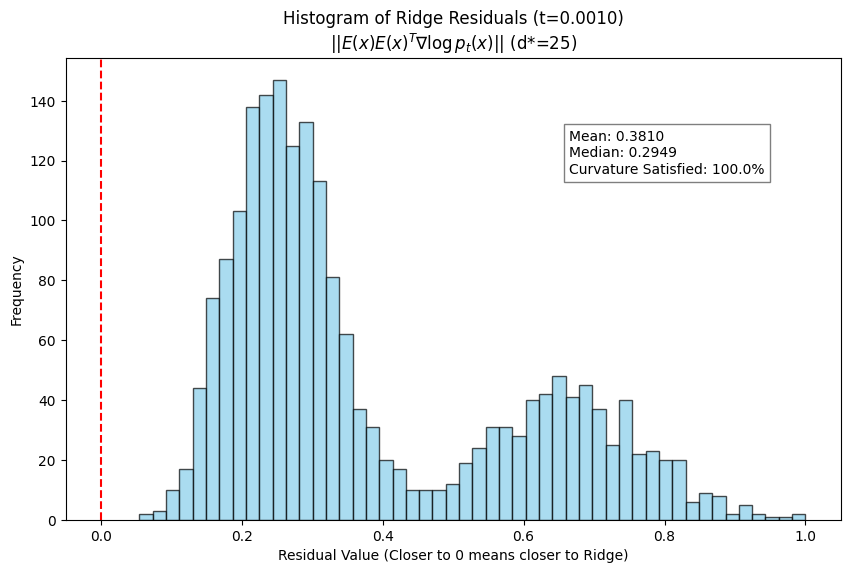

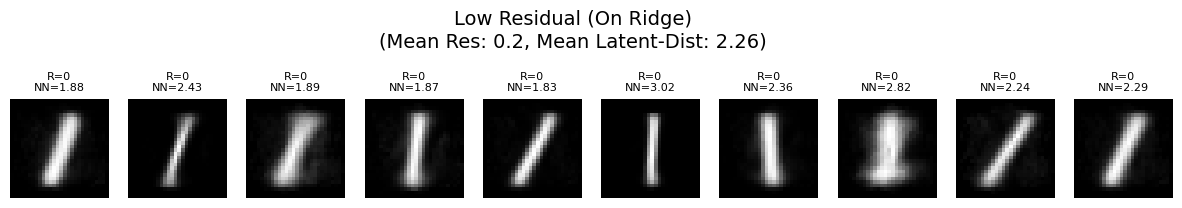

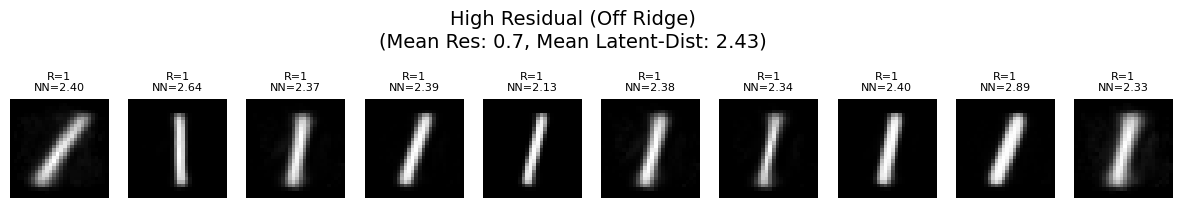

In [112]:
main_analysis()